# Analiza exploratorie a datelor (EDA Complex)
---
Valorile lipsa au fost tratate in prelucrarea setului de date (aceastea au fost simulate, pentru mai multe detalii verifica README). Pentru coloana `relationship_status` putem observa ca apar valori `unknown`, caz in care am considerat `inc_per_dep = monthly_inc / 'single'`.



## Statistici descriptive

Am extras principalele statistici descriptive ale variabilelor numerice: **valoarea minima**, **maxima**, **mediana**, **media**, **deviatia standard**, dar si valorile pentru quantilele **Q1 = 25%** si **Q3 = 75%** (pe care le vom utiliza mai tarziu).

### Ce putem observa?

- Unele variabile au o **diferenta mare intre medie si mediana**, ceea ce indica ori o asimetrie ori o prezenta a unor valori extreme de care ne vom ocupa ulterior
- Pentru variabila `monthly_inc`, media este semnificativ mai mare decat mediana, ceea ce sugereaza faptul ca exista putine persoane considerate bogate care trag media in sus.


In [57]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

# concatenam toate datele intr-un singur dataframe
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

data_df = pd.concat([df_train, df_test], ignore_index=True)

# b) Statistici descriptive
data_df.describe(include="all")


,rev_util,age,debt_ratio,monthly_inc,open_credit,real_estate,late,inc_per_dep,relationship_status,dlq_2yrs
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714,16714.000000,16714,16714.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,6,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,single,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,9662,NaN,7554,NaN
mean,4.799862,48.798672,30.980298,6118.120258,8.503709,1.047445,NaN,4048.198273,NaN,0.500000
std,204.062345,13.906078,719.694859,5931.841779,5.370965,1.272565,NaN,4844.960924,NaN,0.500015
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000
25%,0.082397,38.000000,0.155971,3128.500000,5.000000,0.000000,NaN,1667.250000,NaN,0.000000
50%,0.443080,48.000000,0.322299,5000.000000,8.000000,1.000000,NaN,3000.000000,NaN,0.500000
75%,0.926637,58.000000,0.533426,7573.000000,11.000000,2.000000,NaN,5098.750000,NaN,1.000000


Observam totodata ca pentru coloanele `late` si `relationship_status`, nu se poate face `describe()` asa cum ne dorim, asadar ne vom ocupa de asta, codificand aceste variabile dupa cum urmeaza:
- `late` a fost mapata intr-o scara de severitate: de la 0 la 3
- `relationship_status` a fost mapata in functie de tipul relatiei. Valorile necunoscute (`unknown`) au fost inlocuite cu `single`

In [58]:
# variabilele categorice

late_map = {
    'none': 0,
    'low': 1,
    'medium': 2,
    'severe': 3
}

data_df['late'] = data_df['late'].map(late_map)

data_df['relationship_status'] = data_df['relationship_status'].replace('unknown', 'single')

relationship_map = {
    'single': 0,
    'couple': 1,
    'family': 2,
    '2_kids': 3,
    'extended_family': 4
}

data_df['relationship_status'] = data_df['relationship_status'].map(relationship_map)

data_df[['late', 'relationship_status']].describe()


,late,relationship_status
count,16714.000000,16714.000000
mean,0.864365,0.930657
std,1.171203,1.152798
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,3.000000,4.000000


### Statistici pentru variabilele categorice:
- `late` sugereaza ca majoritatea valorilor sunt `none` sau `low`, ceea este destul de normal pentru noi, asta ne spune ca lumea isi plateste la timp datoriile ;)
- `relationship_status` sugereaza ca cele mai frecventa valori sunt `single` si `couple` si o sa vedem ce influenta are asta asupra delincventei mai tarziu.

#### Hai sa vedem cum arata o histograma pentru una dintre coloane:

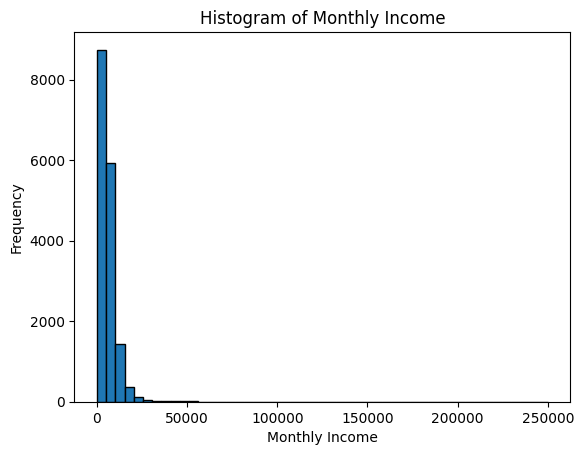

In [59]:
bins = np.linspace(data_df['monthly_inc'].min(), data_df['monthly_inc'].max(), 50)
plt.hist(data_df['monthly_inc'], bins=bins, edgecolor='black')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly Income')
plt.show()

Arata destul de rau... Asta se intampla pentru ca se afla o persoana care a reusit sa sparga matricea si sa aiba un venit lunar de 250k. Pe noi nu ne interseaza aceasta valoare, numita si outlier. Astfel de valori apar in aproape toate coloanele, asa ca vom trata acest caz inainte sa trecem mai departe

## Detectarea outlierilor


Valorile maxime unor coloane sunt destul de mari...

### Cum ne putem ocupa de asta?

R: Trebuie sa analizam **outlierii**.

In [60]:
# IQR pentru a gasi outliers
def calculate_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lwr = q1 - 1.5 * iqr
    uppr = q3 + 1.5 * iqr
    return lwr, uppr

# nu aplicam IQR pe tinta
cols = data_df.select_dtypes(include=np.number).columns.tolist()
cols.remove('dlq_2yrs')
for i in cols:
    lwr, uppr = calculate_iqr(data_df, i)
    #  remove outliers
    data_df[i] = np.clip(data_df[i], lwr, uppr)

print("\nDupa aplicarea IQR\n")
data_df['rev_util'].describe()


Dupa aplicarea IQR



count    16714.000000
mean         0.502803
std          0.418618
min          0.000000
25%          0.082397
50%          0.443080
75%          0.926637
max          2.192996
Name: rev_util, dtype: float64

Observam ca pentru `rev_util` **valoarea maxima** este `2.19`, ceea ce ne deranjeaza deoarece ar trebui sa reprezinta un procentaj, asadar "fortam" un pic termenul de outlier si reducem tot ce are probabilitatea mai mare ca 1.

In [61]:
data_df['rev_util'] = np.where(data_df['rev_util'] > 1, data_df['rev_util'] / 100, data_df['rev_util'])

data_df.describe()


,rev_util,age,debt_ratio,monthly_inc,open_credit,real_estate,late,inc_per_dep,relationship_status,dlq_2yrs
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.0000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000
mean,0.419570,48.788441,0.383739,5728.126316,8.3661,1.018487,0.864365,3736.956747,0.930657,0.500000
std,0.379995,13.875156,0.301025,3484.415979,4.9327,1.096583,1.171203,2693.640797,1.152798,0.500015
min,0.000000,21.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041009,38.000000,0.155971,3128.500000,5.0000,0.000000,0.000000,1667.250000,0.000000,0.000000
50%,0.313866,48.000000,0.322299,5000.000000,8.0000,1.000000,0.000000,3000.000000,0.000000,0.500000
75%,0.814981,58.000000,0.533426,7573.000000,11.0000,2.000000,2.000000,5098.750000,2.000000,1.000000
max,1.000000,88.000000,1.099609,14239.750000,20.0000,5.000000,3.000000,10246.000000,4.000000,1.000000


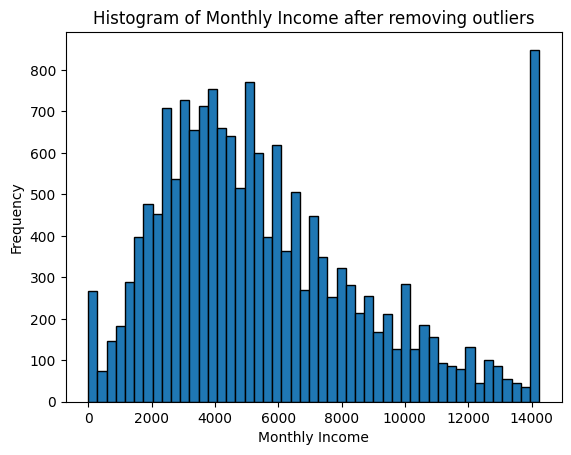

In [62]:
bins = np.linspace(data_df['monthly_inc'].min(), data_df['monthly_inc'].max(), 50)
plt.hist(data_df['monthly_inc'], bins=bins, edgecolor='black')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly Income after removing outliers')
plt.show()

### Acum totul pare sa fie in regula!
Singurul lucru care ne-a mai ramas de facut este sa normalizam totul pentru o eficienta mai buna a antrenarii pe model.

## Analiza distributiei variabilelor

### Limita de pe card

- Cei mai multi clienti au un procent redus din creditul disponibil.
- Pe de alta parte, sunt si multi altii care si-au **suprasolicitat** creditul.
- O valoare cat mai apropiata de 1 indica un **predictor puternic** pentru tinta noastra.

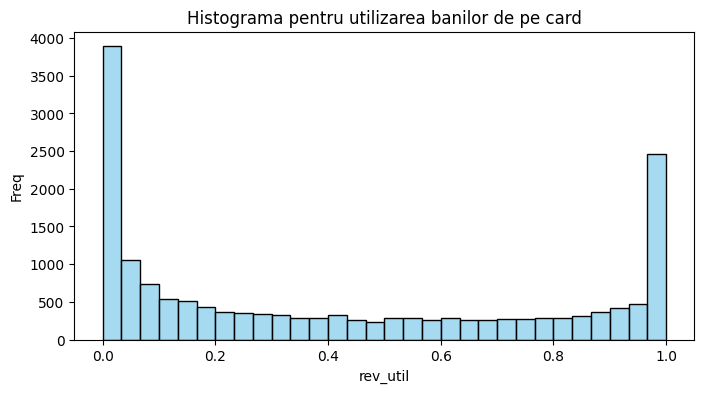

In [63]:
plt.figure(figsize=(8, 4))
sns.histplot(data_df['rev_util'], bins=30, edgecolor='black', color='skyblue')
plt.title(f'Histograma pentru utilizarea banilor de pe card')
plt.xlabel('rev_util')
plt.ylabel('Freq')
plt.show()

### Varsta

- Nu exista valori extreme evidente, deci datele par destul de bine distribuite
- Grupul de varsta dominant este cel al persoanelor mature, probabil cu un istoric financiar stabil.
- Persoanele foarte tinere (<25) sau mai in varsta (>65) fie nu aplica pentru credite, fie nu sunt eligibile

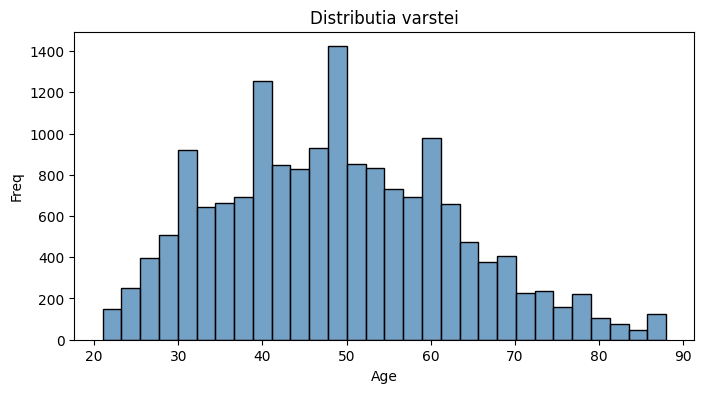

In [64]:
plt.figure(figsize=(8, 4))
sns.histplot(data_df['age'], bins=30, color='steelblue', edgecolor='black')
plt.title('Distributia varstei')
plt.xlabel('Age')
plt.ylabel('Freq')
plt.show()

### Debt Ratio

- Observam ca cea mai mare majoritate au un `debt_ratio` mic, ceea ce inseamna ca aproape niciun ban din venitul lor nu se duce pe datorii, de unde ne dam seama ca ori nu au datorii, ori nu le platesc :D
- Un mare procentaj din oameni de asemenea isi dau cam toti banii pe datorii, de unde tragem concluzia ca aceasta histograma este asimetrica la dreapta, deoarece au valori peste medie.
- Valoarea mare reprezinta un risc pentru delincventa persoanelor

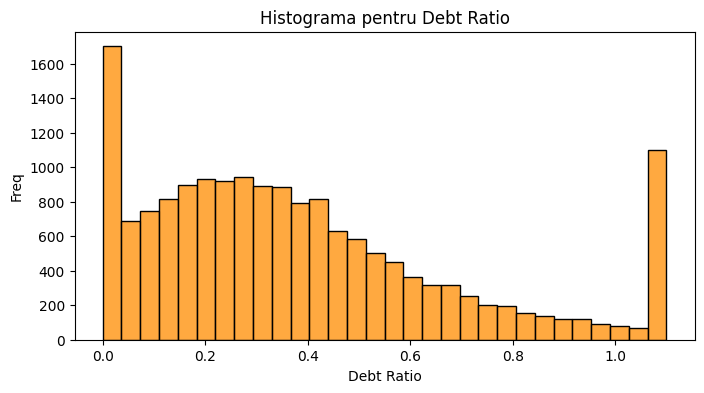

In [65]:
plt.figure(figsize=(8, 4))
sns.histplot(data_df['debt_ratio'], bins=30, color='darkorange', edgecolor='black')
plt.title('Histograma pentru Debt Ratio')
plt.xlabel('Debt Ratio')
plt.ylabel('Freq')
plt.show()

### Venit lunar

- Desi ne-am ocupat de valorile aberante, mai sunt cativa care creeaza o asimetrie in acest grafic.
- Majoritatea persoanelor au salarii intre 0 si 8.000.
- Din ce valori mari observam aici, vom fi nevoiti sa facem o normalizare/standardizare pentru a face o antrenare adecvata

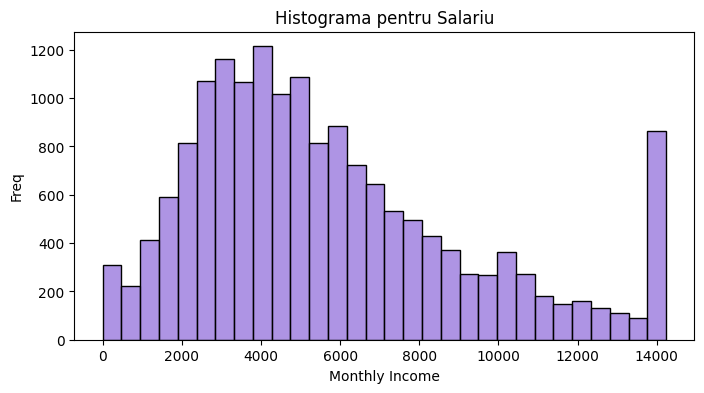

In [66]:
plt.figure(figsize=(8, 4))
sns.histplot(data_df['monthly_inc'], bins=30, color='mediumpurple', edgecolor='black')
plt.title('Histograma pentru Salariu')
plt.xlabel('Monthly Income')
plt.ylabel('Freq')
plt.show()

### Credite active

- Un numar ridicat de conturi deschise indica in general un **risc crescut**, insa noi nu cunoastem ce se intampla in spate, deci ar putea insemna si o **capacitate ridicata de gestionare a creditelor**.
- Majoritatea au intre 2 si 8 linii de credit active.
- Avem o distributie destul de egala ceea ce ne va ajuta mai tarziu.

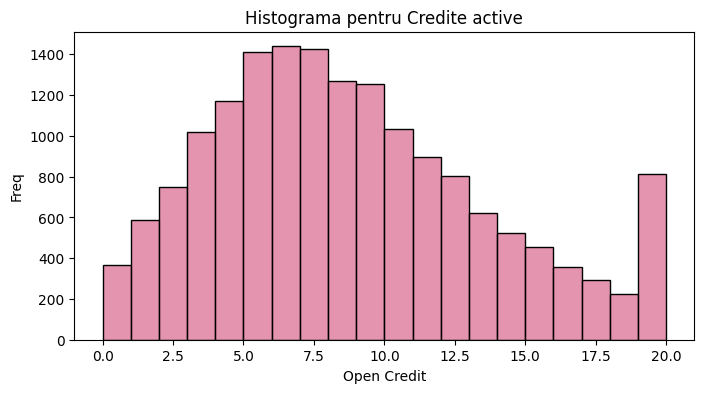

In [67]:
plt.figure(figsize=(8, 4))
bins = range(0, 21)
sns.histplot(data_df['open_credit'], bins=bins, color='palevioletred', edgecolor='black')
plt.title('Histograma pentru Credite active')
plt.xlabel('Open Credit')
plt.ylabel('Freq')
plt.show()

### Real Estate

- Cei mai multi nu prea se baga in acest domeniu.
- Persoanele care detin o proprietate pot fi considerate mai stabile financiar, dar daca ipoteca este mare, pot avea si un `debt_ratio` mai ridicat.

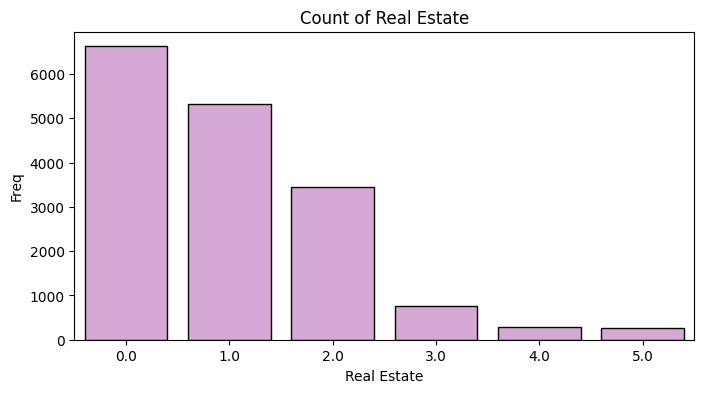

In [68]:
plt.figure(figsize=(8, 4))
sns.countplot(x='real_estate', data=data_df, color='plum', edgecolor='black')
plt.xlabel('Real Estate')
plt.ylabel('Freq')
plt.title('Count of Real Estate')
plt.show()

### Late

- Distributia ne arata faptul ca majoritatea oamenilor **si-au platit toate datoriile la timp**, ceea ce este normal in viata noastra cotidiana.
- Numarul celor cu intarzieri `severe` este mult mai mic, dar important pentru predictia `dlq_2yrs`
- Aceste cazuri specifice determina comportamentul din trecut al clientilor si vor ajuta la antrenarea modelului.

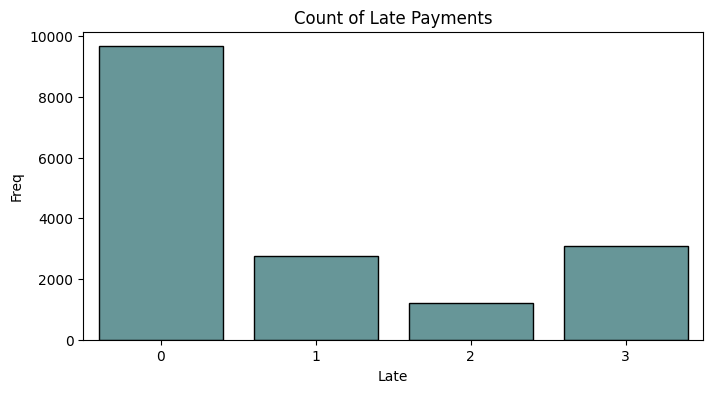

In [69]:
plt.figure(figsize=(8, 4))
sns.countplot(x='late', data=data_df, color='cadetblue', edgecolor='black')
plt.xlabel('Late')
plt.ylabel('Freq')
plt.title('Count of Late Payments')
plt.show()

### Income per dependent

- Dupa calcularea acestei coloane cu formula `monthly_inc / (num_dependents + 1)`, putem observa ca histograma arata aproape identic cu `monthly_inc`, deoarece multa lume au `relationship_status = 'single'`
- Persoanele cu un venit per dependent mai mare au **o capacitate mai buna de rambursare**.

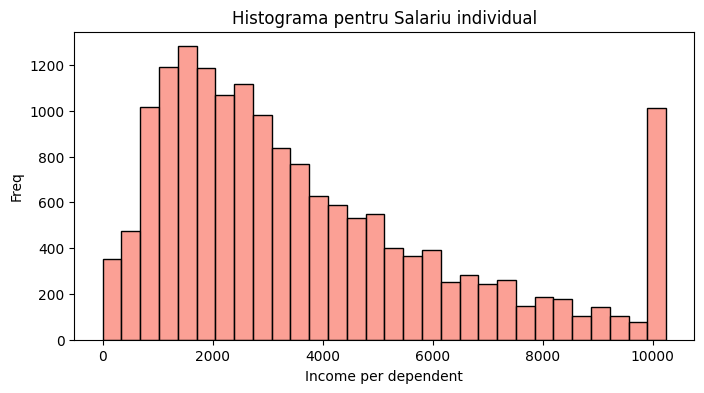

In [70]:
plt.figure(figsize=(8, 4))
sns.histplot(data_df['inc_per_dep'], bins=30, color='salmon', edgecolor='black')
plt.title('Histograma pentru Salariu individual')
plt.xlabel('Income per dependent')
plt.ylabel('Freq')
plt.show()

### Relationship Status

- Majoritatea persoanelor sunt fie `single`, fie `cuplu`.
- Distributia ne ajuta sa intelegem cum responsabilitatile familiale pot afecta comportamentul financiar.


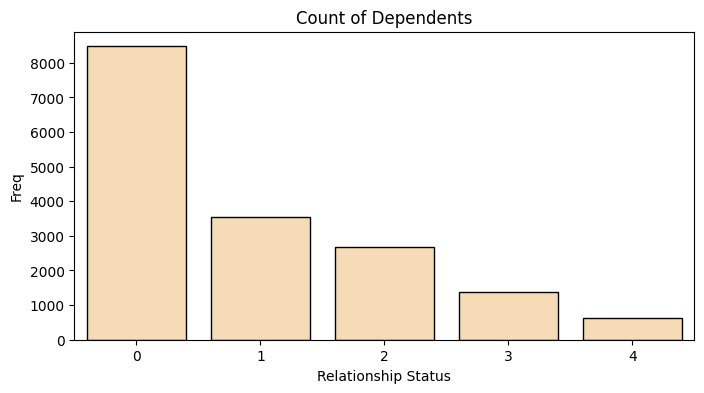

In [71]:
plt.figure(figsize=(8, 4))
sns.countplot(x='relationship_status', data=data_df, color='navajowhite', edgecolor='black')
plt.xlabel('Relationship Status')
plt.ylabel('Freq')
plt.title('Count of Dependents')
plt.show()

### Delinquency over 2 years - **Tinta**

- Distributia este **perfect egala**, ceea ce ne simplifica treaba.
- Nu mai avem nevoie de tehnici de resampling.

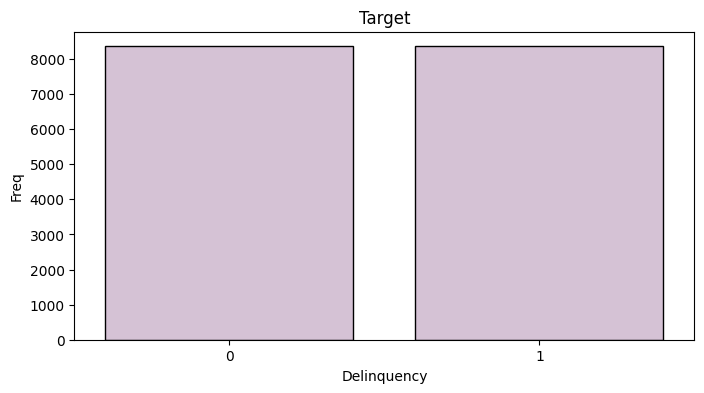

In [72]:
plt.figure(figsize=(8, 4))
sns.countplot(x='dlq_2yrs', data=data_df, color='thistle', edgecolor='black')
plt.xlabel('Delinquency')
plt.ylabel('Freq')
plt.title('Target')
plt.show()

## Normalizare

In [73]:
# Normalizare
for i in cols:
    min_val = data_df[i].min()
    max_val = data_df[i].max()
    data_df[i] = (data_df[i] - min_val) / (max_val - min_val)
print("\nDupa normalizare\n")
data_df.describe()


Dupa normalizare



,rev_util,age,debt_ratio,monthly_inc,open_credit,real_estate,late,inc_per_dep,relationship_status,dlq_2yrs
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000
mean,0.419570,0.414753,0.348978,0.402263,0.418305,0.203697,0.288122,0.364723,0.232664,0.500000
std,0.379995,0.207092,0.273756,0.244696,0.246635,0.219317,0.390401,0.262897,0.288200,0.500015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041009,0.253731,0.141842,0.219702,0.250000,0.000000,0.000000,0.162722,0.000000,0.000000
50%,0.313866,0.402985,0.293104,0.351130,0.400000,0.200000,0.000000,0.292797,0.000000,0.500000
75%,0.814981,0.552239,0.485105,0.531821,0.550000,0.400000,0.666667,0.497633,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Desi am aplicat normalizare, observam ca daca rulam din nou histogramele si countplot-urile, graficele o sa arate identic, doar ca o sa fie in intervalul (0, 1). Toata treaba asta ne ajuta pentru a face o antrenare mai buna pe model.

## Matricea de corelatii

### Legaturile cu matricea de corelatii

- Uitandu-ne pe ultima linie, putem observa ca cea mai stransa legatura o detine coloana `late`, lucru de care vom tine cont cand vom face antrenarea.
- Pentru valori precum `real_estate` si `open_credit` cel mai probabil nu o sa influenteze deloc variabila tinta.

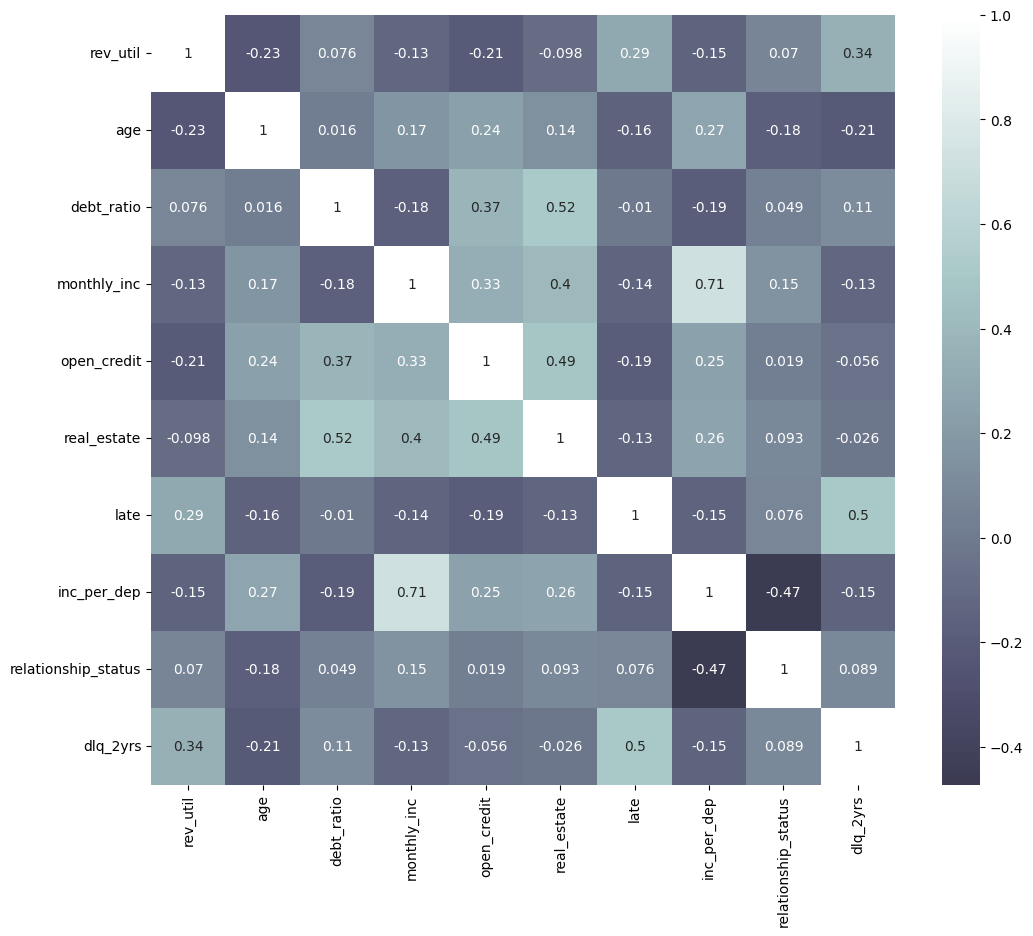

In [74]:
corr_coef = data_df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_coef, annot=True, cmap='bone', center=0)

plt.show()

## Analiza relatiilor cu variabila tinta

Deoarece tipul problemei noastre este una de **clasificare binara**, utilizarea scatter plots-urilor nu va fi alegerea potrivita, asadar vom merge pe `violin plots`


### rev_util

- Clientii care au avut intarzieri tind sa aiba `rev_util` mai mare, ceea ce sugereaza un risc crescut de neplata.
- Vedem ca pentru cei care nu au intarzieri media este chiar spre 0 (`punctul alb`), ceea ce vine si de la sine.

C:\Users\yanis\AppData\Local\Temp\ipykernel_15024\4130788187.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='dlq_2yrs', y='rev_util', palette='Paired')


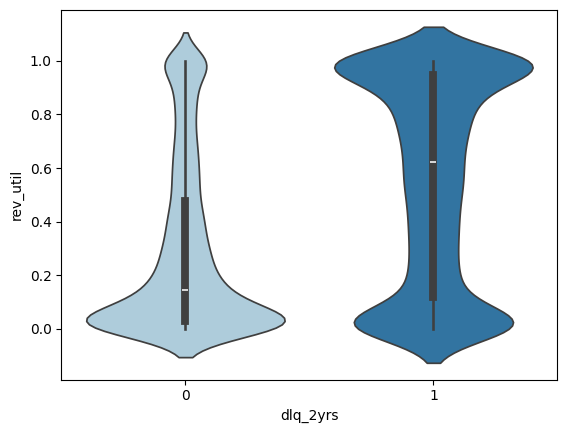

In [75]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='rev_util', palette='Paired')
plt.show()

### Varsta

- Distributia este destul de echilibrata in ambele parti.
- Cei cu intarzieri (`dlq_2yrs = 1`) par sa fie tineri, iar acest lucru poate sugera ca acestia au un risc usor mai mare de întarziere, posibil din cauza unor venituri mai instabile sau a unei experiente financiare mai reduse.

C:\Users\yanis\AppData\Local\Temp\ipykernel_15024\967501098.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='dlq_2yrs', y='age', palette='gnuplot')


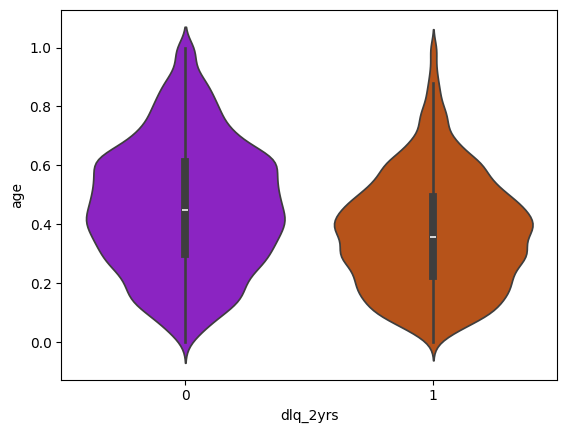

In [76]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='age', palette='gnuplot')
plt.show()

### Debt Ratio

- Aici putem observa ca un debt ratio mai mare creeaza un risc mai mare pentru o delincventa, insa nu sunt cu mult mai multe persoane care creeaza aceasta discrepanta.
- Exista suprapuneri intre cele doua clase, ceea ce inseamna ca nu este suficient pentru o clasificare sigura, insa poate fi util.

C:\Users\yanis\AppData\Local\Temp\ipykernel_15024\2534249105.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='dlq_2yrs', y='debt_ratio', palette='turbo')


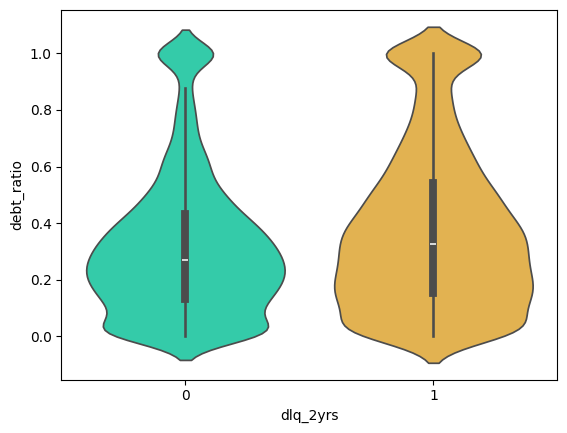

In [77]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='debt_ratio', palette='turbo')
plt.show()

### Salariul lunar

- Sesizam clar venituri mai mici pentru cei care s-au ivit de o delincventa.
- Diferentele nu sunt foarte clare vizual, insa un venit mai mare poate reduce riscul.

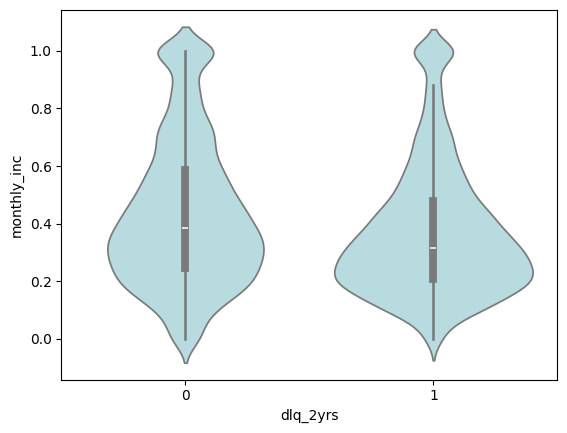

In [78]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='monthly_inc', color='powderblue')
plt.show()

### Credite Active

- In prima instanta, output-ul poate parea contraintuitiv, dar acest lucru ar putea arata o experienta mai mare a clientului in gestionarea creditelor.
- Diferentele nu sunt foarte mari, dar tot pot aduce contributii.

C:\Users\yanis\AppData\Local\Temp\ipykernel_15024\3257237254.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='dlq_2yrs', y='open_credit', palette='nipy_spectral')


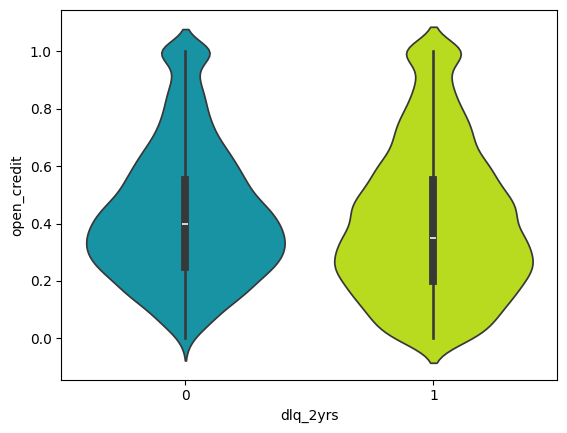

In [79]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='open_credit', palette='nipy_spectral')
plt.show()

### Real Estate

- Vedem clar ca cei mai multi cu delincventa nu au credite imobiliare.
- Putem trage concluzia ca cei care au acces la credite ipotecare au o stabilitate financiara puternic dezvoltata.

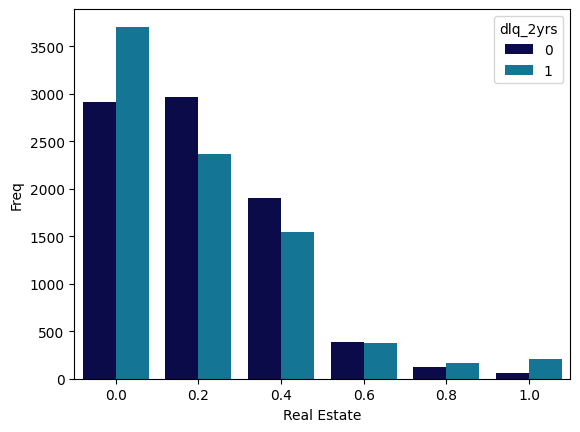

In [80]:
sns.countplot(data=data_df, x='real_estate', hue='dlq_2yrs', palette='ocean')
plt.xlabel('Real Estate')
plt.ylabel('Freq')
plt.legend(title='dlq_2yrs')
plt.show()

### Late Payments

- Este clar ca cei care isi platesc la timp datoriile nu au delincventa.
- Corelatia este logica si asteptata, totul se leaga de comportamentul fiintei umane.

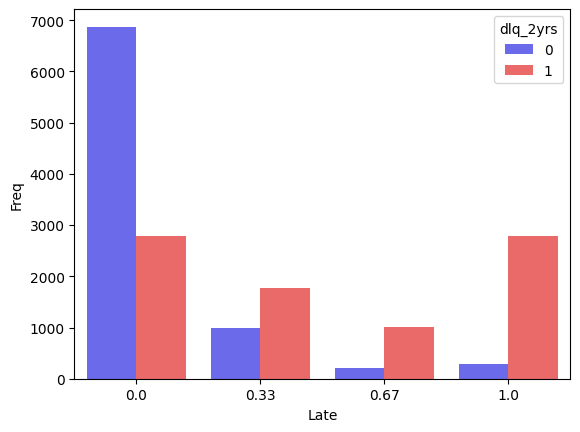

In [81]:
data_df['late'] = data_df['late'].round(2)
sns.countplot(data=data_df, x='late', hue='dlq_2yrs', palette='seismic')
plt.xlabel('Late')
plt.ylabel('Freq')
plt.legend(title='dlq_2yrs')
plt.show()

### Income per Dependent

- Distributia este aproape identice, ceea ce nu prea ne ajuta sa tragem o concluzie in acest caz, vom vedea mai tarziu ce vom face.

C:\Users\yanis\AppData\Local\Temp\ipykernel_15024\670686102.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='dlq_2yrs', y='inc_per_dep', palette='Set1')


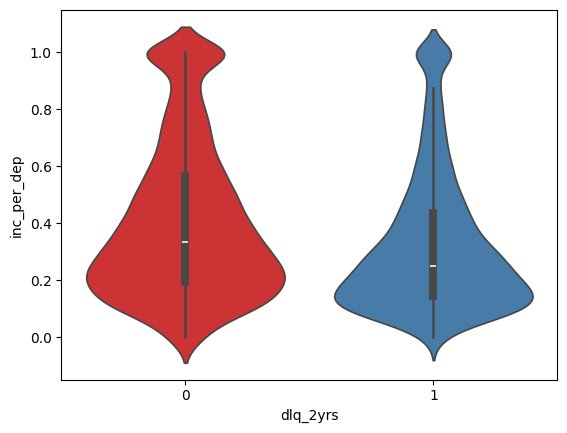

In [82]:
sns.violinplot(data=data_df, x='dlq_2yrs', y='inc_per_dep', palette='Set1')
plt.show()

### Relationship Status

- Persoanele **singure** si **cuplurile** sunt cele mai frecventa in ambele clase.
- Observam o mica diferenta in randul celor fara partener, ce determina o descrestere minora a proportiei delincventei.
- In rest, pare ca cei care au de intretinut o familie ajung sa aiba o intarziere de plata in urmatorii 2 ani.

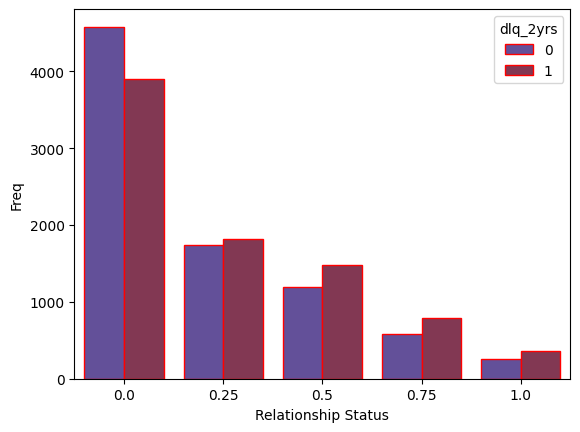

In [83]:
sns.countplot(data=data_df, x='relationship_status', hue='dlq_2yrs', palette='twilight', edgecolor='red')
plt.xlabel('Relationship Status')
plt.ylabel('Freq')
plt.legend(title='dlq_2yrs')
plt.show()

## La final...

Trebuie sa exportam setul de date intr-un alt fisier pe care il vom separa din nou pentru a ne putea antrena pe el. Split-ul va fi facut identic, cu `seed-ul = 42`.

In [84]:
train, test = train_test_split(data_df, test_size=0.1, random_state=42, stratify=data_df['dlq_2yrs'])
train.to_csv('train_final.csv', index=False)
test.to_csv('test_final.csv', index=False)